In [1]:
import pandas as pd
import os

In [35]:
### Summarize Results into a Table

plus_minus = "\u00B1"
table = []
for file in os.listdir("./"):
    
    if file.endswith(".csv"):
        df = pd.read_csv(f"./{file}")
        model = file.split("_results")[0]
        
        mean = df.mean().sort_index()
        std = df.std().sort_index()

        results = {'model': [model]}

        metrics = ['F1@2', 'F1@3', 'F1@4', 'accuracy@2', 'accuracy@3', 'accuracy@4',
       'precision@2', 'precision@3', 'precision@4', 'recall@2', 'recall@3',
       'recall@4']

        for metric in metrics:
            results[metric] = [f"{mean[metric]:.3f}{plus_minus}{std[metric]:.3f}"]
        
        table.append(pd.DataFrame(results))
        

table = pd.concat(table)
table = table.sort_values(by='F1@4', ascending=False)
table

,model,F1@2,F1@3,F1@4,accuracy@2,accuracy@3,accuracy@4,precision@2,precision@3,precision@4,recall@2,recall@3,recall@4
0,resnet18,0.935±0.017,0.912±0.030,0.868±0.045,0.939±0.014,0.936±0.014,0.901±0.037,0.937±0.018,0.902±0.032,0.865±0.054,0.935±0.019,0.930±0.037,0.886±0.047
0,convnext,0.935±0.023,0.908±0.033,0.865±0.045,0.939±0.022,0.936±0.020,0.904±0.035,0.940±0.025,0.902±0.034,0.869±0.051,0.933±0.022,0.922±0.042,0.878±0.050
0,efficientnet,0.926±0.017,0.899±0.031,0.853±0.055,0.931±0.016,0.924±0.017,0.891±0.043,0.928±0.018,0.890±0.037,0.850±0.063,0.926±0.017,0.919±0.038,0.876±0.061
0,resnet18npt,0.928±0.019,0.904±0.030,0.839±0.059,0.933±0.018,0.928±0.017,0.878±0.049,0.933±0.020,0.894±0.035,0.834±0.065,0.925±0.020,0.924±0.035,0.863±0.053
0,resnet152,0.926±0.019,0.893±0.031,0.830±0.056,0.931±0.016,0.925±0.016,0.871±0.048,0.928±0.019,0.891±0.036,0.831±0.061,0.926±0.020,0.903±0.042,0.854±0.059
0,small_cnn,0.793±0.055,0.701±0.067,0.634±0.061,0.807±0.048,0.742±0.068,0.676±0.052,0.808±0.044,0.690±0.054,0.644±0.061,0.800±0.064,0.787±0.054,0.708±0.054


In [36]:
filtered_table = table[['model'] + [col for col in table.columns if col.endswith('@4')]]
filtered_table

,model,F1@4,accuracy@4,precision@4,recall@4
0,resnet18,0.868±0.045,0.901±0.037,0.865±0.054,0.886±0.047
0,convnext,0.865±0.045,0.904±0.035,0.869±0.051,0.878±0.050
0,efficientnet,0.853±0.055,0.891±0.043,0.850±0.063,0.876±0.061
0,resnet18npt,0.839±0.059,0.878±0.049,0.834±0.065,0.863±0.053
0,resnet152,0.830±0.056,0.871±0.048,0.831±0.061,0.854±0.059
0,small_cnn,0.634±0.061,0.676±0.052,0.644±0.061,0.708±0.054


# Significance Testing

* t-test (Welch's) on each metric to see if there is a significant difference in any model results


In [72]:
import numpy as np
import pandas as pd
from matplotlib.colors import ListedColormap
import scipy.stats as stats
import matplotlib.pyplot as plt

def pairwise_sig_test(means, stds, model_names, alpha=0.05, n=18):
    num_models = len(means)
    p_values = np.zeros((num_models, num_models))
    significance = np.zeros((num_models, num_models), dtype=bool)
    
    for i in range(num_models):
        for j in range(num_models):
            if i != j:
                t_stat, p_value = stats.ttest_ind_from_stats(means[i], stds[i], n, means[j], stds[j], n, equal_var=False)
                p_values[i, j] = p_value
                significance[i, j] = p_value < alpha
            else:
                p_values[i, j] = 0.0
                significance[i, j] = False

    
    plt.figsize = (10, 10)
    fig, ax = plt.subplots()
    cmap = plt.cm.Blues
    cax = ax.matshow(-np.log1p(p_values), cmap=cmap)
    
    for (i, j), val in np.ndenumerate(p_values):
        if i != j:
            ax.text(j, i, f'{val:.3f}', ha='center', va='center', color='white' if p_values[i,j] < 0.5 else 'black')
        else:
            ax.text(j, i, '', ha='center', va='center')
            
    ax.set_xticks(np.arange(num_models))
    ax.set_yticks(np.arange(num_models))
    ax.set_xticklabels(model_names, rotation=45)
    ax.set_yticklabels(model_names)
    
    plt.colorbar(cax, ticks=[0, 1], label='p-value')
    plt.show()

def sig_test(metric):
    means = []
    stds = []
    model_names = []
    for file in os.listdir("./"):
    
        if file.endswith(".csv"):
            df = pd.read_csv(f"./{file}")
            model = file.split("_results")[0]
            model_names.append(model)
            means.append(df[metric].mean())
            stds.append(df[metric].std())
            
    sorted_indices = np.argsort(means)[::-1]
    means = np.array(means)[sorted_indices]
    stds = np.array(stds)[sorted_indices]
    model_names = np.array(model_names)[sorted_indices]

    pairwise_sig_test(means, stds, model_names)
    return
    

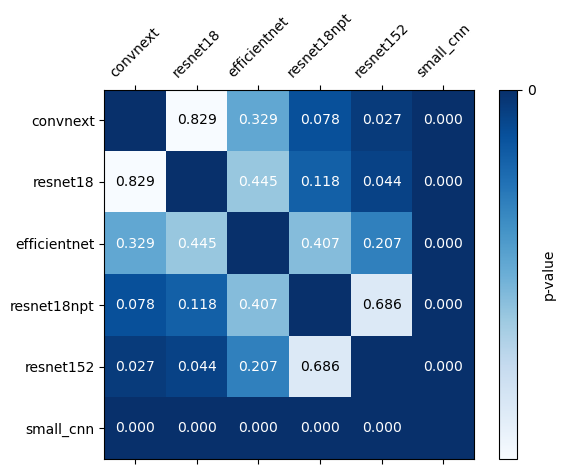

In [77]:
sig_test('accuracy@4')